# IMPORTS

* Import all the needed libraries for the notebook
* Mount the drive containing the datasets
* Unzip the dataset







In [1]:
import sys
import os
from natsort import natsorted
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import trunc
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.layers.core import Dense, Dropout, Activation 
from keras.utils import np_utils
from keras.layers import LeakyReLU   
from keras.regularizers import l2  
from keras.models import Model                   
from pathlib import Path

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

# Data preparation

Get all the bboxes path and all the img_paths
Additionally read all the text files corresponding to the bounding boxes and append them to a list.
**bboxes** contains lists of bounding boxes, one per image

In [2]:
  #-------------#
  #| EGO HANDS |#
  #------------ #

#Get from the unzipped dataset the list of all the paths of images and txt files
#listdir returns unsorted so use natsorted method!

#paths needed for the training set
bboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\egoHands\boundingboxes'))
img_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\egoHands\frames'))

assert len(bboxes_paths) == len(img_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

#Read all the text files and create a list of list of bounding boxes for the training, one list per image 
bboxes = []*len(bboxes_paths)
for path in bboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        box = line.split(',')
        if(not(int(box[0]) == 0 and int(box[1]) == 0 and int(box[2]) == 0 and int(box[3]) == 0)):
            bboxes_it.append([int(x) for x in box])
    bboxes.append(bboxes_it)

assert(len(bboxes) == len(img_paths))

In [ ]:
  #------------------------#
  #| HEGO HORIZONTAL FLIP |#
  #------------------------#

horizontalBboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\HorizontalFlip\boundingboxes_horizontalflip'))
horizontalImg_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\HorizontalFlip\images_horizontalflip'))

assert len(horizontalBboxes_paths) == len(horizontalImg_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

for path in horizontalBboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        box = line.split(',')
        if(not(int(box[0]) == 0 and int(box[1]) == 0 and int(box[2]) == 0 and int(box[3]) == 0)):
            bboxes_it.append([int(x) for x in box])
    bboxes.append(bboxes_it)

for path in horizontalImg_paths:
    img_paths.append(path)

assert(len(bboxes) == len(img_paths))

In [ ]:
#---------------------#
#| EGO VERTICAL FLIP |#
#---------------------#

verticalBboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\VerticalFlip\boundingboxes_verticalflip'))
verticalImg_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\VerticalFlip\images_verticalflip'))

assert len(verticalBboxes_paths) == len(verticalImg_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

for path in verticalBboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        box = line.split(',')
        if(not(int(box[0]) == 0 and int(box[1]) == 0 and int(box[2]) == 0 and int(box[3]) == 0)):
            bboxes_it.append([int(x) for x in box])
    bboxes.append(bboxes_it)

for path in verticalImg_paths:
    img_paths.append(path)

assert(len(bboxes) == len(img_paths))

In [3]:
#---------------#
#| COLOR HANDS |#
#---------------#

colorBboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\ColorDA\boundingboxes'))
colorImg_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\ColorDA\frames'))

assert len(colorBboxes_paths) == len(colorImg_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

for path in colorBboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        bboxes_it.append([int(float(x)) for x in line.split(',')])
    bboxes.append(bboxes_it)

for path in colorImg_paths:
    img_paths.append(path)

assert(len(bboxes) == len(img_paths))

In [4]:
#------------#
#| NO HANDS |#
#------------#
noHands_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\noHands'))

for path in noHands_paths:
    img_paths.append(path)
    bboxes.append([])

assert(len(bboxes) == len(img_paths))

In [ ]:
#-------------------#
#| HANDS OVER FACE |#
#-------------------#

hofBboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\handsOverFaces\boundingboxes'))
hofImg_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\handsOverFaces\frames'))

assert len(hofBboxes_paths) == len(hofImg_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

for path in hofBboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        bboxes_it.append([int(float(x)) for x in line.split(',')])
    bboxes.append(bboxes_it)

for path in hofImg_paths:
    img_paths.append(path)

assert(len(bboxes) == len(img_paths))

# BATCH GENERATOR

This class generates batches of data from the list of bboxes and img_paths, in this way new batches are genereated every epoch and ram problems, derived from creating a single really big X and Y, are avoided.

The images and boxes have to be passed converted in a specific format in order for Yolo to work:

Each input image is resized to 448x448 format as required by Yolo for its input.
Now create the grid of cells that Yolo analyzes.
The size of the grid is 8x8 meaning that each cell will have a size of 52x52.

For each bounding box calculate its center, the center will be the grid at which the bounding box is associated.
Each grid cell has a bounding box associated with it (zero if no bounding box). The bounding box has this form [P, Ox, Oy, W, H]:


*   P = probability that there's a hand (always 1 since we are taking ground truth boxes)
*   Ox = X center of the bounding box w.r.t to that grid, each grid has coordinates defined by (0,0) and (1,1) being respectively the up-left and down-rigth corner of such grid
*   Oy = Y center with same reasoning as above
*   W = width of the bounding box w.r.t the grid size
*   H = height of the bounding box w.r.t. the grid size

So, as an example, a bounding box b = [208,208,104,104] will be associated to the cell at row = 3 and column = 3 and become b_new = [1 ,0.5 ,0.5 , 2, 2]



In [7]:
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path_list, bboxes_list, batch_size=32, dim=(448,448,3),
                 divisions=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.path_list = path_list
        self.S = divisions
        self.bboxes_list = bboxes_list
        self.shuffle = shuffle
        self.on_epoch_end() #triggered at beginning and end of each epoch
        self.cell_size = dim[0]/divisions

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.path_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
         # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True: # For more robust data
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size,self.S,self.S,5))
        
        batch_num = 0
        # Generate data
        for i in indexes:
            original_img = load_img(self.path_list[i])
            width, height = original_img.size
            # load the image with the required size and calculate scale factors
            image = load_img(self.path_list[i], target_size=(448, 448))
            scale_w = 448 / width 
            scale_h = 448 / height
            image = img_to_array(image)
            # scale pixel values to [0, 1]
            image = image.astype('float32')
            image /= 255.0
            y_img = np.zeros((self.S,self.S,5))
            for box in self.bboxes_list[i]:
                xleft = int(box[0] * scale_w)
                yleft = int(box[1] * scale_h)
                b_width = int(box[2] * scale_w)
                b_height = int(box[3] * scale_h)
                ox = xleft + b_width/2
                oy = yleft + b_height/2
                # Calculate the coordinates of the cell in the grid that contains the center 
                grid_col = trunc(ox/self.cell_size)
                grid_row = trunc(oy/self.cell_size) 
                # Calculate the coordinates of the center of the bbox w.r.t the associated cell; (0,0) top left and (1,1) bottom right corners of the cell
                ox_cell = (ox - (grid_col)*self.cell_size)/self.cell_size
                oy_cell = (oy - (grid_row)*self.cell_size)/self.cell_size
                # Calculate the width and height of the bbox in terms of cell size, a bbox of width 448/S(cell size) will have grid_width = 1
                grid_width = b_width/448
                grid_heigth = b_height/448
                # Put the results into y; 1 represent the probability of the class
                y = [1,ox_cell,oy_cell,grid_width,grid_heigth]
                y_img[grid_row][grid_col] = y
        
            # Store sample
            X[batch_num,] = image

            # Store grid
            Y[batch_num,] = y_img
        
            batch_num += 1

        return X, Y

# LOSS FUNCTION
Definition of the loss function as the one used in the paper but simpler.

There are just 5 parameters for each cell [P, x, y, w, h] thus one bounding box per cell.

Hence penalize the sum square root of x,y,(w)^1/2,(h)^1/2 as in the paper but just for the cells that contain a box so those with P = y_true[0] = 1.

Then penalize the sum square root of P.

Then penalize the sum square root of P for the cells that do not contain boxes hence with P = y_true[0] = 0.


In [9]:
def custom_loss(y_true, y_pred):
    # y_true (Batch size, 7, 7, 5)
    # y_pred (Batch size, 7, 7, 5)

    mse = tf.keras.losses.MeanSquaredError(reduction = "sum") # Define the SUM squared error loss
    predictions = tf.reshape(y_pred,(-1,7,7,5)) # The predictions are a tensor, need some reshaping to manipulate it

    exists_box = tf.expand_dims(y_true[...,0], 3) # A box exists if the first entry of the cell is equal to 1 

    #------------#
    #| BOX LOSS |#
    #------------#

    pred_box = exists_box*predictions[...,1:5] #Calculate only loss for the cells that contain a box
    target_box = exists_box*y_true[...,1:5] #Target boxes

    epsilon = tf.fill(tf.shape(pred_box[..., 2:4]), 1e-6) #Needed to avoid divergence of square root derivatives in back propagation

    # width and height are penalyzed using the square root, however predictions can be negative so multiply by sign in order to obtain positive
    # and take absoulte value in the square root 
    wh_pred = tf.math.sign(pred_box[...,3:5]) * tf.math.sqrt(tf.math.abs(pred_box[...,3:5] + epsilon))
    wh_targ = tf.math.sqrt(target_box[...,3:5] + epsilon)

    # Get also centers
    xy_pred = pred_box[...,1:3]
    xy_true = target_box[...,1:3]

    # Concatenate the new xy and wh in order to calculate sum squared root
    final_pred_box = tf.concat([xy_pred,wh_pred], axis = 3)
    final_true_box = tf.concat([xy_true,wh_targ], axis = 3)
    box_loss = mse(tf.reshape(final_pred_box, (-1, tf.shape(final_pred_box)[-1])),tf.reshape(final_true_box, (-1, tf.shape(final_true_box)[-1])))
    
    #---------------#
    #| OBJECT LOSS |#
    #---------------#
    
    # Take only the first entry of each box corresponding to the probability that there's an object
    pred_obj = predictions[...,0:1]
    true_obj = y_true[...,0:1]

    #Calculate object loss as in the paper
    object_loss = mse(tf.reshape(exists_box*pred_obj, (-1, )), tf.reshape(exists_box*true_obj, (-1, )) )

    #------------------#
    #| NO OBJECT LOSS |#
    #------------------#

    # Calculate the loss for cells that don't have objects
    non_exists_box = 1 - exists_box
    no_object_loss = mse(tf.reshape(non_exists_box*pred_obj, (-1, )), tf.reshape(non_exists_box*true_obj, (-1, )))

    #--------------#
    #| FINAL LOSS |#
    #--------------#

    # Penalize more the box loss and less the no object loss   
    total_loss = 5*box_loss + object_loss + 0.5*no_object_loss
    return total_loss

In [10]:
# Test that the loss function works returning a numpy number
x = tf.random.uniform((2, 7, 7, 5))
y = tf.random.uniform((2, 7, 7, 5))
custom_loss(x,y)

<tf.Tensor: shape=(), dtype=float32, numpy=26.3626>

# Custom architecture
The following cell creates a custom sequential model inspired from Yolo.
Many iterations over the architecture have been performed and this is the one that proved itself to be better.

The feature extractor works by alternating 3x3 convolutions with 1x1 convolutions and increasing constantly the number of filters. Batch Normalization is used to avoid overfitting.
The activation function is a leaky Relu with slope of 0.1.

The detection is performed by using a fully connected layer that is then reshaped to have a final output of 7x7x5 containg the predictions of the grid.
All the values of the prediction are in range [0,1] hence a sigmoid activation function is used.


In [2]:
#-------------#
#| YOLO BEST |#
#-------------#

tf.keras.backend.clear_session()

yolo = Sequential()

yolo.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=(448,448,3), use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2)))

yolo.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2)))

yolo.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(64, (1, 1), padding="valid", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2)))

yolo.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(128, (1, 1), padding="valid", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2)))

yolo.add(tf.keras.layers.Conv2D(1024, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(512, (1, 1), padding="valid", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.Conv2D(1024, (3, 3), padding="same", use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2)))

yolo.add(tf.keras.layers.Conv2D(1024, (3, 3), padding="same", strides = (2,2), use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))

yolo.add(tf.keras.layers.Conv2D(512, (1, 1), padding="valid", strides = (2,2), use_bias = False))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))

yolo.add(tf.keras.layers.Reshape((8192,), input_shape=(4,4,512)))

yolo.add(Dense(245, activation = 'sigmoid'))

yolo.add(tf.keras.layers.Reshape((7,7,5), input_shape=(245,)))

yolo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 448, 448, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 448, 448, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18432     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     2

In [4]:
#IF YOU WANT TO LOAD THE TRAINED MODEL WEIGHTS COMPILE THIS CELL
yolo.load_weights(r'C:\Users\franc\Desktop\Yolo_Hand\Model\yolo_best.h5')

# TRAINING
Perform the training of the custom model.
The weights are saved at the end of every epoch to perform training over multiple sessions.

The optimizer uses a small learning rate in order to avoid divergence of the loss.

In [36]:
from keras.optimizers import adam_v2

training_generator = DataGenerator(img_paths, bboxes)
checkpoint_filepath = '/content/drive/MyDrive/CheckPoints/yolo_best.h5'
adam = adam_v2.Adam(learning_rate=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)

yolo.compile(loss=custom_loss, optimizer=adam)

In [ ]:
history = yolo.fit(x = training_generator, epochs=7, workers = 1, verbose=1, callbacks=[model_checkpoint_callback])

In [ ]:
from scipy.io import savemat

#Save the matrices for the plots
mdic = {"loss": history.history['loss'] }
savemat(r'C:\Users\franc\Desktop\Yolo_Hand\TrainResults\loss_small416.mat', mdic)

# TESTING
Visualize how the model works in some test images

In [5]:
#Function to transform the output of the network in the correct format
def decode_net_out(out):
    # IN : out [7x7x5]
    # RETURNS : bboxes [list] of the best training boxes
    cell_size = 448/7
    bboxes = []
    confidences = []
    for i in range(0,7):
        for j in range(0,7):
            if out[i][j][0] > 0.6: #CONFIDENCE THRESHOLD (P of the cell)
                bbox = np.zeros((4))
                ox_cell = out[i][j][1]
                oy_cell = out[i][j][2]
                w_cell = out[i][j][3]
                h_cell = out[i][j][4]
                if(ox_cell != 0 and oy_cell !=0):
                    ox = int(ox_cell*cell_size + cell_size*j)
                    oy = int(oy_cell*cell_size + cell_size*i)
                    w = w_cell*448
                    h = h_cell*448
                    lx = ox - w/2
                    ly = oy - h/2
                    bbox = [out[i][j][0],int(lx),int(ly),int(w),int(h)]
                    bboxes.append(bbox)
    return bboxes

# TESTING ON EVALUATION SET!

In [6]:
test_bboxes_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\Test_Hands\Bboxes'))
test_img_paths = natsorted(listdir_fullpath(r'C:\Users\franc\Desktop\Yolo_Hand\Hand_DATASET\Test_Hands\Images'))

#Read all the text files and create a list of list of bounding boxes, one list per image 
test_bboxes = []*len(test_bboxes_paths)
for path in test_bboxes_paths:
    bboxes_it = []
    file = open(path, 'r')
    Lines = file.readlines()
    for line in Lines:
        bboxes_it.append([int(x) for x in line.split()]) #Separated by white spaces
    test_bboxes.append(bboxes_it)

#Creation of the scaled down 448x448 version of the ground truth bboxes 
test_bboxes_scaled = []
for i in range(0,len(test_img_paths)):
    bboxes_it = []
    original_img = load_img(test_img_paths[i])
    width, height = original_img.size
    scale_w = 448 / width 
    scale_h = 448 / height

    for box in test_bboxes[i]:
        xleft = int(box[0] * scale_w)
        yleft = int(box[1] * scale_h)
        b_width = int(box[2] * scale_w)
        b_height = int(box[3] * scale_h)
        new_bbox = [xleft,yleft,b_width,b_height]
        bboxes_it.append(new_bbox)
    test_bboxes_scaled.append(bboxes_it)

In [7]:
def calc_iou(prop_bbox, ground_truth):
    #This function takes as input a single prop_bbox and a single ground_truth bbox and return their intersection 
    #over union

    P,p_x, p_y, p_w, p_h = prop_bbox
    g_x, g_y, g_w, g_h = ground_truth

    #Non overlapping cases then IoU = 0.0:
    #-Bottom_right smaller than top left
    if((p_x + p_w) < g_x):
        return 0.0
    if((p_y + p_h) < g_y):
        return 0.0
    if((g_x + g_w) < p_x):
        return 0.0
    if((g_y + g_h) < p_y):
        return 0.0

    #Top left corner of intersection
    x_in = max(p_x, g_x)
    y_in = max(p_y, g_y)
    #Bottom right corner of intersection
    x1_in = min(p_x + p_w, g_x + g_w)
    y1_in = min(p_y + p_h, g_y + g_h)
    w_in = x1_in - x_in
    h_in = y1_in - y_in
    #Area intersection
    area_in = w_in * h_in

    #Area union
    area_un = (p_w * p_h) + (g_w * g_h) - area_in

    #Intersection Over Union
    IoU = area_in / area_un

    return IoU

In [8]:
def single_img_results(prop_bboxes, true_bboxes):
    #This function returns the average IOU for a single image given its proposed bboxes and corresponding
    #ground truth

    if(len(prop_bboxes)== 0):
        return 0.0

    max_Ious = []

    #For each ground truth find the prop bbox that overlaps the most
    for true_bbox in true_bboxes:
        Iou_results = []
        for prop_bbox in prop_bboxes:
            Iou_results.append(calc_iou(prop_bbox,true_bbox))
        max_Ious.append(max(Iou_results))

    #If there are more ground truth than len of max_Ious fill the list with 0s until their lenght are the same
    if(len(true_bboxes)>len(max_Ious)):
        app = [0.0]*len(len(true_bboxes)-len(max_Ious))
        max_Ious.append(app)

    avg_Iou = sum(max_Ious)/len(max_Ious)
    return(avg_Iou)

Now for each test image get the average IoU of the ground truth bboxes (IN GREEN) and proposed bboxes (IN RED)

1/1 [==============================] - 0s 281ms/step
Image average IOU : 0.4179550201534392


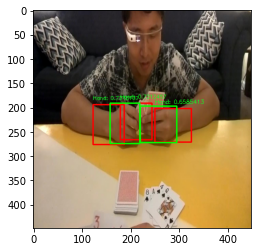

1/1 [==============================] - 0s 287ms/step
Image average IOU : 0.3035027730407181


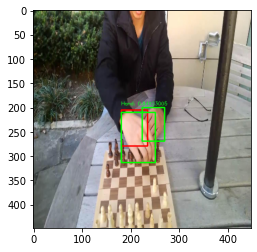

1/1 [==============================] - 0s 287ms/step
Image average IOU : 0.2840276835391505


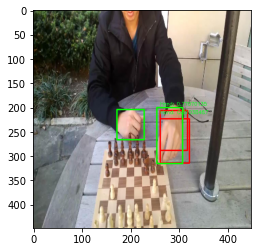

1/1 [==============================] - 0s 281ms/step
Image average IOU : 0.5264793135771959


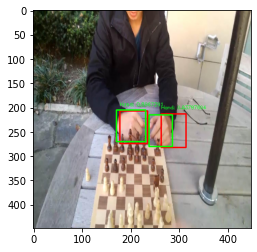

1/1 [==============================] - 0s 286ms/step
Image average IOU : 0.43759170856835405


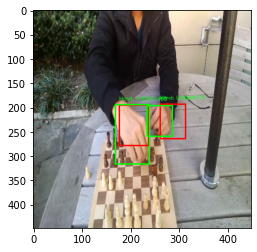

1/1 [==============================] - 0s 290ms/step
Image average IOU : 0.5404509745806022


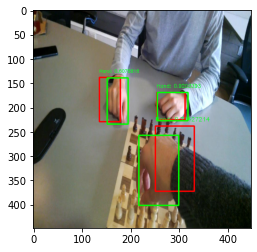

1/1 [==============================] - 0s 294ms/step
Image average IOU : 0.37928057794704445


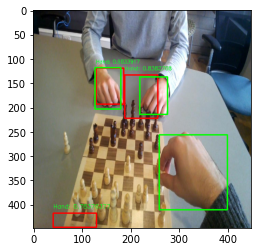

1/1 [==============================] - 0s 288ms/step
Image average IOU : 0.3992174232263377


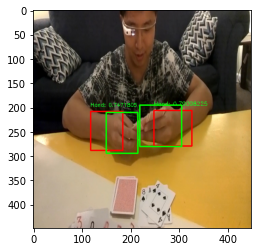

1/1 [==============================] - 0s 287ms/step
Image average IOU : 0.0


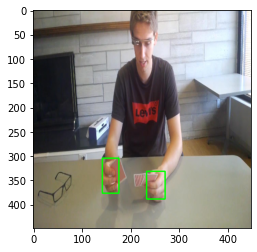

1/1 [==============================] - 0s 290ms/step
Image average IOU : 0.4699384187312289


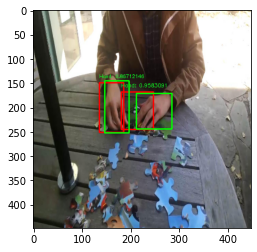

1/1 [==============================] - 0s 285ms/step
Image average IOU : 0.630321272125995


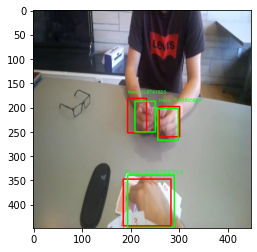

1/1 [==============================] - 0s 291ms/step
Image average IOU : 0.6695899738419211


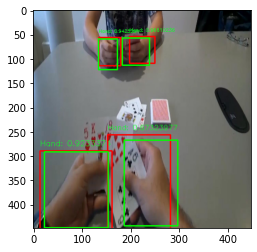

1/1 [==============================] - 0s 290ms/step
Image average IOU : 0.24973032065147305


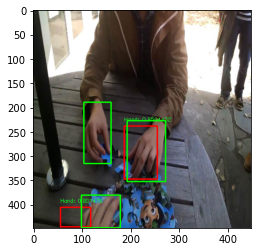

1/1 [==============================] - 0s 284ms/step
Image average IOU : 0.3428755548833579


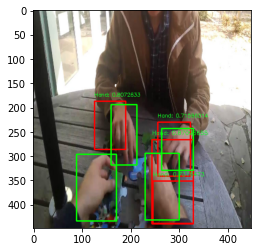

1/1 [==============================] - 0s 277ms/step
Image average IOU : 0.28589292279536743


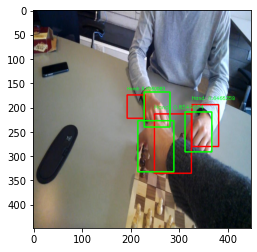

1/1 [==============================] - 0s 291ms/step
Image average IOU : 0.0880550942801501


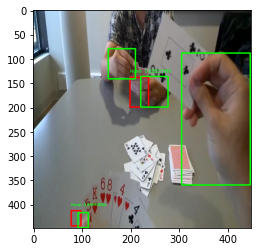

1/1 [==============================] - 0s 291ms/step
Image average IOU : 0.563895083563905


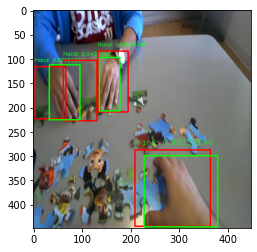

1/1 [==============================] - 0s 296ms/step
Image average IOU : 0.3126833340044146


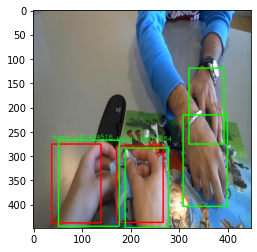

1/1 [==============================] - 0s 272ms/step
Image average IOU : 0.6573775676892817


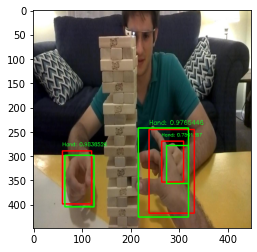

1/1 [==============================] - 0s 289ms/step
Image average IOU : 0.2570376002570412


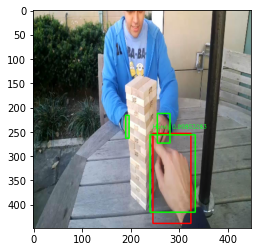

1/1 [==============================] - 0s 289ms/step
Image average IOU : 0.5712693103997452


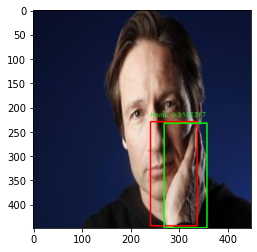

1/1 [==============================] - 0s 286ms/step
Image average IOU : 0.1012216404886562


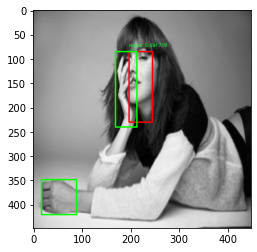

1/1 [==============================] - 0s 280ms/step
Image average IOU : 0.7652173913043478


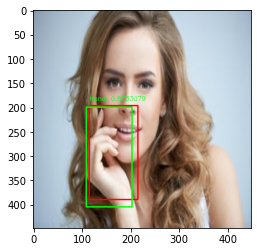

1/1 [==============================] - 0s 307ms/step
Image average IOU : 0.0


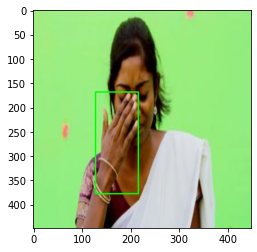

1/1 [==============================] - 0s 287ms/step
Image average IOU : 0.7146919385573262


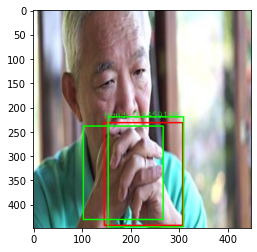

1/1 [==============================] - 0s 284ms/step
Image average IOU : 0.9211771598539817


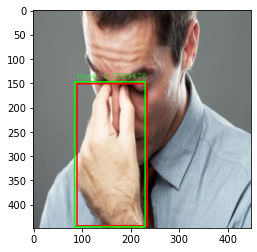

1/1 [==============================] - 0s 291ms/step
Image average IOU : 0.4232206548676768


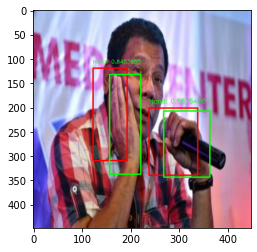

1/1 [==============================] - 0s 381ms/step
Image average IOU : 0.9373381294964028


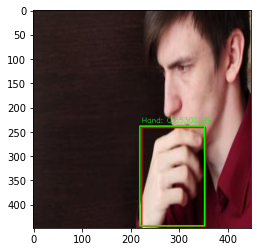

1/1 [==============================] - 0s 290ms/step
Image average IOU : 0.0


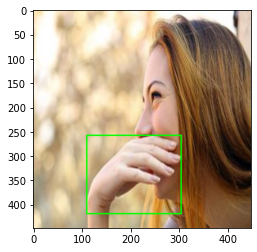

1/1 [==============================] - 0s 280ms/step
Image average IOU : 0.0


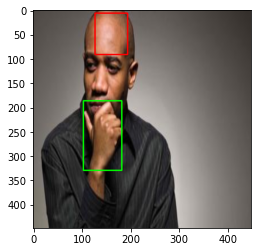

TEST DATASET AVERAGE IOU = 0.4083346280808372


In [13]:
avg_Ious = []
for i in range(0, len(test_img_paths)):
    loaded_img = load_img(test_img_paths[i], target_size=(448, 448))
    image = img_to_array(loaded_img)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    in_net = np.expand_dims(image, axis=0) #Expand dimension because the network works with batches as input

    out_net = yolo.predict(in_net)
    prop_bboxes = decode_net_out(out_net[0])

    avg_Iou = single_img_results(prop_bboxes, test_bboxes_scaled[i])
    print("Image average IOU : " + str(avg_Iou))
    avg_Ious.append(avg_Iou)

    #DRAW THE IMAGE
    image = cv2.imread(test_img_paths[i])
    width,height,channels = image.shape
    scale_w = 448/width
    scale_h = 448/height
    image_show = cv2.resize(image,(448,448))
    # Drawing the regions in the Image
    for (P,x, y, w, h) in prop_bboxes:
        cv2.rectangle(image_show, (x, y), 
                      (x + w, y + h), 
                       (0, 0, 255), 2)
        cv2.putText(image_show, 'Hand: ' + str(P), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, w/448 + 0.2, (36,255,12), 1)
    for (x, y, w, h) in test_bboxes_scaled[i]:
        cv2.rectangle(image_show, (x, y), 
                      (x + w, y + h), 
                       (0, 255, 0), 2)
    im_show_rgb = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB)
    window_name = 'image'
    plt.imshow(im_show_rgb)
    plt.show()

print("TEST DATASET AVERAGE IOU = " + str(sum(avg_Ious)/len(avg_Ious)))